# Neural Network Training

In [83]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class Layer :
    def __init__(self,weight,bias) :
        self.weight = weight
        self.bias =  bias
        
    def activationSigmoid(self,input) : #Sigmoid
        sigmoid = torch.sigmoid(input)
        return sigmoid
    
    def activationRelu(self,input) : #Sigmoid
        m = nn.ReLU()
        return m(input)
    
    def activationSM(self,input) : #Sigmoid
        m = nn.Softmax(dim=1)
        return m(input)
        
    def forward1(self, input) :
        output=(torch.mm(input.double(),self.weight.double()))+self.bias
        return output,self.activationRelu(output).double()
    
    
    def forward2(self, input) :
        output=(torch.mm(input.double(),self.weight.double()))+self.bias
        return output,self.activationSM(output).double()
        
    
       
class Network:
    def __init__(self,w1,b1,w2,b2, batch_size = 10):
        self.batch_size = batch_size
        # network
        self.layer1 = Layer(w1,b1)
        self.layer2 = Layer(w2,b2)

    def forward1(self, x):
        pred,a = self.layer1.forward1(x)
        return pred,a
    
    def forward2(self, x):
        pred,y = self.layer2.forward2(x)
        return pred,y

    
    def single_processing(self, input, target) :
            pred1,error1 = self.forward1(input)
            pred2,error2 = self.forward2(error1)
            return pred1.double(),error1.double(),pred2.double(),error2.double()
            
    
    def evaluate(self, pred, target) : #L1
        loss = nn.L1Loss()
        output = loss(pred,target)
        return output        
                
    #Create batch, then process each batch
    def batch_processing(self, input, target) :
        for i in range(0,len(input)-1,2):
            new_len=[input[i].tolist(),input[i+1].tolist()]
            new_ten=torch.Tensor(new_len)
            new_tar=[target[i].tolist(),target[i+1].tolist()]
            new_tar2=torch.Tensor(new_tar)
            self.single_processing(new_ten,new_tar2)

# Load Data

In [65]:
trainset= MNIST('dataset_mnist',True, download= True)
trainset= MNIST('dataset_mnist',False, download= True)

In [66]:
trainset.data.shape

torch.Size([10000, 28, 28])

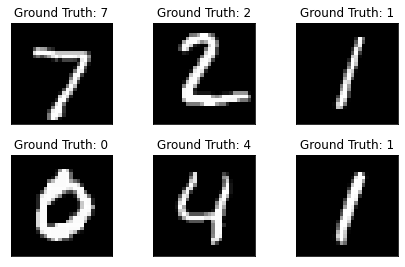

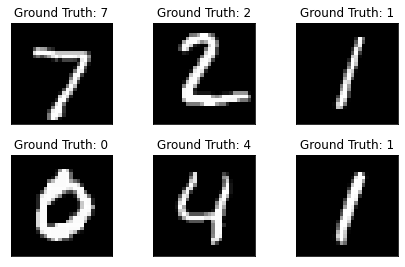

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trainset[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(trainset.targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [68]:

print(trainset.targets)

tensor([7, 2, 1,  ..., 4, 5, 6])


# Modeling Data

In [115]:
x_train=trainset.data
y_train=trainset.targets
x_train=x_train.reshape(-1,28*28)
x_train=x_train.float()
x_train=x_train/255
print(x_train.shape)
x_train=x_train[:8000]
print(x_train.shape)
y_train=y_train[:8000]
print(y_train.shape)

torch.Size([10000, 784])
torch.Size([8000, 784])
torch.Size([8000])


# Call Neural Network Training Class

In [122]:
seed=52
learning_rate=0.01

m, n = x_train.shape
print (m,n)
acc=0

                
def Y_res(Y):
    Y_res = np.zeros((list(y_train.shape)[0], 10))
    Y_res[np.arange(list(y_train.shape)[0]), Y] = 1
    #one_hot_Y = one_hot_Y.T
    return Y_res.astype(float)
   
def ReLU_deriv(Z):
    return (Z > 0) * 1
    
    
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
        Z1=Z1.numpy()
        Z2=Z2.numpy()
        A1=A1.numpy()
        A2=A2.numpy()
        W2=W2.numpy()
        W1=W1.numpy()
        Y_result = Y_res(Y)
        dZ2 = A2 - Y_result
        dW2 = 1 / m * dZ2.T.dot(A1)
        db2 = 1 / m * np.sum(dZ2)
        
        dZ1 = W2.T.dot(dZ2.T) * ReLU_deriv(Z1).T
        dW1 = 1 / m * dZ1.dot(X)
        db1 = 1 / m * np.sum(dZ1)

        return torch.tensor(dW1).double(), torch.tensor(db1).double(), torch.tensor(dW2).double(), torch.tensor(db2).double()
        
def get_predictions(A2):
    return torch.argmax(A2, 0)

def get_accuracy(predictions, Y):
    acc=0
    print(predictions.size())
    for i in range (1000):
        if predictions[i]==Y[i]:
            acc=acc+1
            #print("sama",predictions[i],Y[i])
    #return torch.sum(predictions == Y) / m
    return acc / m
    
def forward_prop(w1, b1, w2, b2 , X):
    model = Network(w1,b1,w2,b2)
    pred1,error1,pred2,error2=model.single_processing(x_train,y_train)
    return pred1.double(), error1.double(), pred2.double(), error2.double()
        
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - (alpha * dW1).T
    b1 = b1 - alpha * db1
    W2 = W2 - (alpha * dW2).T  
    b2 = b2 - alpha * db2
    return torch.tensor(W1), torch.tensor(b1),torch.tensor(W2), torch.tensor(b2)

def init_params():
    torch.manual_seed(52)
    w1 = torch.randn((784,10))
    b1 =  torch.randn((10))
    #layer2
    w2 = torch.randn((10,10))
    b2 =  torch.randn((10))
    return w1,b1,w2,b2

def weight_decay(X):
    return X

def early_Stop(X):
    if(X>1):
        return "stop"
    
def gradient_descent(X, Y, alpha, iterations):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        #print("awal: ",w2)
        Z1, A1, Z2, A2 = forward_prop(w1,b1,w2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y)
        w1,b1,w2, b2 = update_params(w1,b1,w2, b2, dW1, db1, dW2, db2,alpha)
        #print("Akhir: ",w2)
        print("Iteration: ", i)
        predictions = get_predictions(A2.t())
        print("Predict: ", predictions, "Y:", Y)
        print(get_accuracy(predictions, Y))
    return w1.double(),b1.double(),w2.double(), b2.double()


W1, b1, W2, b2 = gradient_descent(x_train, y_train, 0.01, 10000)


8000 784
Iteration:  0
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008625
Iteration:  1
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.00875
Iteration:  2
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008875
Iteration:  3
Predict:  

C:\Users\Intel\AppData\Local\Temp\ipykernel_11392\2493395346.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(W1), torch.tensor(b1),torch.tensor(W2), torch.tensor(b2)


tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.009125
Iteration:  4
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008875
Iteration:  5
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008875
Iteration:  6
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008875
Iteration:  7
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008875
Iteration:  8
Predict:  tensor([6, 1, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.008875
Iteration:  9
Predict:  tensor([6, 1, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.009
Iteration:  10
Predict:  tensor([6, 1, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.009
Iteration:  11
Predict:  tensor([6, 1, 3,  ..., 3, 3, 3]) Y: 

Iteration:  72
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.02
Iteration:  73
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.020125
Iteration:  74
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.02025
Iteration:  75
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.020375
Iteration:  76
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0205
Iteration:  77
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.020625
Iteration:  78
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.020625
Iteration:  79
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.02075
Iteration:  80
Predict:  tensor(

Iteration:  140
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.025875
Iteration:  141
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.025625
Iteration:  142
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.025625
Iteration:  143
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.025625
Iteration:  144
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.025625
Iteration:  145
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.02575
Iteration:  146
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.02575
Iteration:  147
Predict:  tensor([6, 1, 2,  ..., 3, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.025875
Iteration:  148
Pr

Iteration:  211
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.031375
Iteration:  212
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.031375
Iteration:  213
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.031375
Iteration:  214
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0315
Iteration:  215
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.031875
Iteration:  216
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.032
Iteration:  217
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.032375
Iteration:  218
Predict:  tensor([6, 1, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0325
Iteration:  219
Predict

Iteration:  281
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.036375
Iteration:  282
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.036375
Iteration:  283
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0365
Iteration:  284
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0365
Iteration:  285
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.036625
Iteration:  286
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.03675
Iteration:  287
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.036625
Iteration:  288
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.03675
Iteration:  289
Predic

Iteration:  350
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.041625
Iteration:  351
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.041875
Iteration:  352
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.041875
Iteration:  353
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.042
Iteration:  354
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.042
Iteration:  355
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.042
Iteration:  356
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.042125
Iteration:  357
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04225
Iteration:  358
Predict:  

Iteration:  421
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.044375
Iteration:  422
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.044625
Iteration:  423
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04475
Iteration:  424
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04475
Iteration:  425
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04475
Iteration:  426
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04475
Iteration:  427
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.044625
Iteration:  428
Predict:  tensor([7, 3, 2,  ..., 2, 7, 4]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.044625
Iteration:  429
Pred

Iteration:  489
Predict:  tensor([7, 3, 2,  ..., 2, 7, 7]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04775
Iteration:  490
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.04775
Iteration:  491
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.048
Iteration:  492
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.048
Iteration:  493
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.048125
Iteration:  494
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.048125
Iteration:  495
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.048125
Iteration:  496
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.048125
Iteration:  497
Predict:

Iteration:  558
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  559
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  560
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  561
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  562
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  563
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  564
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  565
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  566
Predict: 

Iteration:  629
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05475
Iteration:  630
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05475
Iteration:  631
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  632
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055
Iteration:  633
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  634
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055
Iteration:  635
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055
Iteration:  636
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055
Iteration:  637
Predict:  tens

Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  700
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  701
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  702
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  703
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  704
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  705
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  706
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  707
Predict:  tensor

Iteration:  769
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05775
Iteration:  770
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  771
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  772
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  773
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  774
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  775
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  776
Predict:  tensor([7, 1, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057875
Iteration:  777
P

Iteration:  837
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  838
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  839
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  840
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  841
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  842
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  843
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  844
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  845
P

Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  905
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  906
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  907
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  908
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  909
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  910
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  911
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  912
Predict:  tensor

Iteration:  972
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  973
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  974
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  975
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  976
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  977
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  978
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  979
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  980
Predict:

Iteration:  1040
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  1041
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  1042
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1043
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1044
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1045
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1046
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1047
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:

Iteration:  1110
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1111
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1112
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1113
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1114
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1115
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1116
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1117
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1118
Predict

Iteration:  1178
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1179
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1180
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1181
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1182
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1183
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1184
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1185
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1186
P

Iteration:  1247
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1248
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1249
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1250
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1251
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1252
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1253
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1254
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:

Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  1317
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1318
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1319
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1320
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1321
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1322
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1323
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059375
Iteration:  1324
Predict: 

Iteration:  1383
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1384
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1385
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1386
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1387
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1388
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1389
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1390
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteratio

Iteration:  1453
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  1454
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  1455
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1456
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1457
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1458
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05875
Iteration:  1459
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1460
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  146

Iteration:  1523
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1524
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1525
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1526
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1527
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1528
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1529
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  1530
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteratio

Iteration:  1592
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05875
Iteration:  1593
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05875
Iteration:  1594
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05875
Iteration:  1595
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1596
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1597
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1598
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  1599
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  16

Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1662
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1663
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1664
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1665
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1666
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1667
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1668
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058625
Iteration:  1669
Predict:  tensor([

Iteration:  1729
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1730
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1731
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1732
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1733
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1734
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1735
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1736
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1737
Predict

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1799
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1800
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1801
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1802
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  1803
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1804
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1805
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  1806
Predict:  tens

Iteration:  1867
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  1868
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  1869
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  1870
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1871
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1872
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1873
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1874
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1875


Iteration:  1934
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  1935
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  1936
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  1937
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1938
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1939
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1940
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1941
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  1942


Iteration:  2002
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2003
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2004
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2005
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2006
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2007
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2008
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058
Iteration:  2009
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2010
Predict:  ten

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2072
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2073
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2074
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2075
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2076
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2077
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2078
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2079
Predict:  te

Iteration:  2139
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2140
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2141
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2142
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2143
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2144
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2145
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2146
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059125
Iteration:  2147
Pre

Iteration:  2206
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2207
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2208
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2209
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2210
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2211
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2212
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2213
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  22

Iteration:  2274
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2275
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2276
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2277
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2278
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2279
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2280
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2281
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2282

Iteration:  2342
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2343
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2344
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2345
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2346
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2347
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2348
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2349
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0585
Iteration:  2350
Predict

Iteration:  2411
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2412
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2413
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.059
Iteration:  2414
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2415
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2416
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2417
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2418
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058875
Iteration:  2419


Iteration:  2478
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2479
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2480
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2481
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2482
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2483
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2484
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2485
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05925
Iteration:  2486

Iteration:  2548
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2549
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2550
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2551
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2552
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2553
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2554
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2555
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration: 

Iteration:  2616
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2617
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2618
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2619
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058375
Iteration:  2620
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2621
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2622
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2623
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2686
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2687
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2688
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2689
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2690
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2691
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2692
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05825
Iteration:  2693
Predict:  tensor

Iteration:  2752
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2753
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2754
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2755
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2756
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2757
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2758
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteration:  2759
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.058125
Iteratio

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2821
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2822
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2823
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2824
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2825
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2826
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2827
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057625
Iteration:  2828
Predict:

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2888
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2889
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2890
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2891
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2892
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2893
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2894
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2895
Predict:

Iteration:  2957
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2958
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2959
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2960
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2961
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2962
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2963
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  2964
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteratio

Iteration:  3026
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3027
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3028
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3029
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3030
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3031
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3032
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057375
Iteration:  3033
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05725
Iteration

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057
Iteration:  3095
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057
Iteration:  3096
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057
Iteration:  3097
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3098
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3099
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3100
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3101
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3102
Predict:  tensor([

Iteration:  3164
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3165
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3166
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3167
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3168
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3169
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3170
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3171
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3172
Predict

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3234
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3235
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3236
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3237
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3238
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3239
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3240
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3241
Predict:  tensor

Iteration:  3303
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3304
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3305
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3306
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3307
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3308
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3309
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3310
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3311

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3372
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3373
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3374
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3375
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3376
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3377
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3378
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  3379
Predict:  tensor([7, 2, 2,  .

Iteration:  3439
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3440
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3441
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3442
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3443
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3444
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3445
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  3446
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteratio

Iteration:  3508
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3509
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3510
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3511
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3512
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3513
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3514
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3515
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  35

Iteration:  3577
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3578
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3579
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3580
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3581
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3582
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3583
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3584
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  3585

Iteration:  3645
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3646
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3647
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3648
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3649
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3650
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3651
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3652
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteratio

Iteration:  3715
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3716
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3717
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3718
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3719
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3720
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3721
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  3722
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  37

Iteration:  3783
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3784
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3785
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3786
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3787
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3788
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3789
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  3790
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteratio

Iteration:  3850
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3851
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3852
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3853
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3854
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3855
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3856
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3857
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  3858
Predict

Iteration:  3920
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3921
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3922
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3923
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3924
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3925
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3926
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  3927
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteratio

0.05675
Iteration:  3987
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3988
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3989
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3990
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3991
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3992
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3993
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  3994
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteratio

Iteration:  4054
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4055
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4056
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4057
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4058
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4059
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4060
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4061
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4062
Predict

Iteration:  4123
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4124
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4125
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4126
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4127
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4128
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4129
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4130
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4131
Predict

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4192
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4193
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4194
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4195
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4196
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4197
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4198
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4199
Predict:  tensor([7, 2, 

Iteration:  4261
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4262
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4263
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4264
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4265
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4266
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4267
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4268
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4269

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4330
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4331
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4332
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4333
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4334
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4335
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4336
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056625
Iteration:  4337
Predict:

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  4397
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  4398
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  4399
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  4400
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056875
Iteration:  4401
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4402
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4403
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4404
Predict:  t

Iteration:  4466
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4467
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4468
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4469
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4470
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4471
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4472
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4473
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteratio

Iteration:  4536
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05725
Iteration:  4537
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05725
Iteration:  4538
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05725
Iteration:  4539
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05725
Iteration:  4540
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4541
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4542
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4543
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4605
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4606
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4607
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4608
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4609
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4610
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4611
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.057125
Iteration:  4612
Predict:

Iteration:  4671
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4672
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4673
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4674
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4675
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4676
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4677
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4678
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4679

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4741
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4742
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4743
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4744
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4745
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4746
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4747
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05675
Iteration:  4748
Predict:  tensor

Iteration:  4809
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4810
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4811
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0565
Iteration:  4812
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  4813
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  4814
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  4815
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  4816
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056375
Iteration:  48

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4877
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4878
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4879
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4880
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4881
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4882
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4883
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05625
Iteration:  4884
Predict:  tensor

Iteration:  4944
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4945
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4946
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4947
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4948
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4949
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4950
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  4951
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteratio

Iteration:  5011
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5012
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5013
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5014
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5015
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5016
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5017
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteration:  5018
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056125
Iteratio

Iteration:  5081
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5082
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5083
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5084
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5085
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5086
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5087
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5088
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.056
Iteration:  5089
Predict:  tenso

Iteration:  5149
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5150
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5151
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5152
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5153
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5154
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5155
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5156
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5157

Iteration:  5217
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5218
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5219
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5220
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5221
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5222
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5223
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5224
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5225

Iteration:  5287
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5288
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5289
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5290
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5291
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5292
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5293
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5294
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5295

Iteration:  5357
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5358
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5359
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5360
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5361
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5362
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5363
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5364
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5365

Iteration:  5424
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5425
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5426
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5427
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5428
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5429
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5430
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5431
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05525
Iteration:  5432

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5492
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5493
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5494
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5495
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5496
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5497
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5498
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.055125
Iteration:  5499
Predict:

Iteration:  5562
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5563
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5564
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5565
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5566
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5567
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5568
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteration:  5569
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054875
Iteratio

Iteration:  5632
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5633
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5634
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5635
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5636
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5637
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5638
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5639
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteratio

Iteration:  5699
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5700
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5701
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5702
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5703
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5704
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5705
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5706
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteratio

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5768
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5769
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5770
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5771
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05475
Iteration:  5772
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05475
Iteration:  5773
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05475
Iteration:  5774
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05475
Iteration:  5775
Predict:  te

Iteration:  5836
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5837
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5838
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5839
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5840
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5841
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5842
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5843
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteratio

Iteration:  5906
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5907
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5908
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5909
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5910
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5911
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5912
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteration:  5913
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054625
Iteratio

Iteration:  5973
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5974
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5975
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5976
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5977
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5978
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5979
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  5980
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteratio

Iteration:  6040
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6041
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6042
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6043
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6044
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6045
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6046
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6047
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0545
Iteration:  6048
Predict

Iteration:  6110
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054375
Iteration:  6111
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  6112
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  6113
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  6114
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  6115
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  6116
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  6117
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05425
Iteration:  611

Iteration:  6178
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054125
Iteration:  6179
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6180
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6181
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6182
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6183
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6184
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6185
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6186
Predict:  te

Iteration:  6248
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6249
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6250
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6251
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6252
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6253
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6254
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6255
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6256
Predict:  tenso

Iteration:  6316
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6317
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6318
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6319
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6320
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6321
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6322
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6323
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.054
Iteration:  6324
Predict:  tenso

Iteration:  6386
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6387
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6388
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6389
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6390
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6391
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6392
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6393
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6394

Iteration:  6454
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6455
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6456
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6457
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6458
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6459
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6460
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6461
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteratio

Iteration:  6523
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6524
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6525
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6526
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6527
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6528
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6529
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6530
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05375
Iteration:  6531

Iteration:  6590
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6591
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6592
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6593
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6594
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6595
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6596
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteration:  6597
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053875
Iteratio

Iteration:  6658
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6659
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6660
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6661
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6662
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6663
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6664
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6665
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6666
Predict

Iteration:  6729
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6730
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6731
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6732
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6733
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6734
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6735
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6736
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6737
Predict

Iteration:  6796
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6797
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6798
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6799
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6800
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6801
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6802
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6803
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6804
Predict

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6864
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6865
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6866
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6867
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6868
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6869
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6870
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053625
Iteration:  6871
Predict:

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6931
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6932
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6933
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6934
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6935
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6936
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6937
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:  6938
Predict:  tensor([7, 2, 

Iteration:  7000
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7001
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7002
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7003
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7004
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7005
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7006
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7007
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteratio

Iteration:  7067
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7068
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7069
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7070
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7071
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7072
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7073
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053375
Iteration:  7074
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0535
Iteration:

Iteration:  7135
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7136
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7137
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7138
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7139
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7140
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7141
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7142
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7143

Iteration:  7203
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7204
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7205
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7206
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7207
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7208
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7209
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7210
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteratio

Iteration:  7273
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7274
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7275
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7276
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7277
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7278
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7279
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7280
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7281
Predict: 

Iteration:  7341
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7342
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7343
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7344
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7345
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7346
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7347
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7348
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  7

Iteration:  7408
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7409
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7410
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7411
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7412
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7413
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7414
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7415
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteratio

Iteration:  7478
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7479
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7480
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7481
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7482
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7483
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7484
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7485
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7486
Predict:  te

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7549
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7550
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7551
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7552
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7553
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7554
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7555
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7556
Predict:

Iteration:  7616
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7617
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7618
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7619
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7620
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7621
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7622
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7623
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteratio

Iteration:  7686
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7687
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7688
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7689
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7690
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7691
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7692
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  7693
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteratio

Iteration:  7754
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7755
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7756
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7757
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7758
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7759
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7760
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7761
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  7762

Iteration:  7824
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7825
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7826
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7827
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7828
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7829
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7830
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7831
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  7832
Predict:  tenso

Iteration:  7894
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7895
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7896
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7897
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7898
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7899
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7900
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7901
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteratio

Iteration:  7964
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7965
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7966
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7967
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7968
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7969
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7970
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  7971
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteratio

Iteration:  8033
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8034
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8035
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8036
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8037
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8038
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8039
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8040
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05325
Iteration:  8041

Iteration:  8100
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053125
Iteration:  8101
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8102
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8103
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8104
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8105
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8106
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8107
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8108
Predict:  te

Iteration:  8168
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8169
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8170
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8171
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8172
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8173
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8174
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8175
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  8176
Predict:  tenso

Iteration:  8236
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  8237
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  8238
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  8239
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  8240
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  8241
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8242
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8243
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration: 

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8304
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8305
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8306
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8307
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8308
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8309
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8310
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8311
Predict:  tensor

Iteration:  8371
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8372
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8373
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8374
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8375
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8376
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8377
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8378
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8379

Iteration:  8440
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8441
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8442
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8443
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8444
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8445
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8446
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8447
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8448

Iteration:  8510
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8511
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8512
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8513
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8514
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8515
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8516
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8517
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  8518

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  8578
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  8579
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  8580
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  8581
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  8582
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052625
Iteration:  8583
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  8584
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  8585
Predict:  te

Iteration:  8645
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8646
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8647
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8648
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8649
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8650
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8651
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  8652
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteratio

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8714
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8715
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8716
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8717
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8718
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8719
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8720
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8721
Predict:  tensor

Iteration:  8784
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8785
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8786
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8787
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8788
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8789
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8790
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8791
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8792
Predict:  tenso

Iteration:  8852
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8853
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8854
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8855
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8856
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8857
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8858
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8859
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8860
Predict:  tenso

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8921
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  8922
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  8923
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  8924
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  8925
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  8926
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  8927
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  8928
Predict:  tens

Iteration:  8990
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8991
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8992
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8993
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8994
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8995
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8996
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8997
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  8998

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9059
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9060
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9061
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9062
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9063
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9064
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9065
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9066
Predict:  tensor

Iteration:  9125
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9126
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9127
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9128
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9129
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9130
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9131
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9132
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05225
Iteration:  9133

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9195
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9196
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9197
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9198
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9199
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9200
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9201
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052
Iteration:  9202
Predict:  tensor([7, 2, 2,  ...,

Iteration:  9262
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9263
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9264
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9265
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9266
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9267
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9268
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9269
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteratio

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9330
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9331
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9332
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9333
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9334
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9335
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9336
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052125
Iteration:  9337
Predict:

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9399
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9400
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9401
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9402
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9403
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9404
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9405
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052375
Iteration:  9406
Predict:

Iteration:  9466
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9467
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9468
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9469
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9470
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9471
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9472
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9473
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9474
Predict

Iteration:  9533
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9534
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9535
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9536
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9537
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9538
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9539
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9540
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0525
Iteration:  9541
Predict

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9602
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9603
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9604
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9605
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9606
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9607
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9608
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9609
Predict:  tensor

Iteration:  9671
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9672
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9673
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9674
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9675
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9676
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9677
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9678
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.05275
Iteration:  9679

Iteration:  9739
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9740
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9741
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9742
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9743
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9744
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9745
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9746
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteratio

Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9808
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9809
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9810
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9811
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9812
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9813
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9814
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9815
Predict:

Iteration:  9874
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9875
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9876
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9877
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9878
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9879
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9880
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteration:  9881
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.052875
Iteratio

Iteration:  9944
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9945
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9946
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9947
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9948
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9949
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9950
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9951
Predict:  tensor([7, 2, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.053
Iteration:  9952
Predict:  tenso

# Validation

In [119]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    #current_image = current_image.reshape((28, 28)) * 255
    #plt.gray()
    #plt.imshow(current_image, interpolation='nearest')
    #plt.show()
    
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Prediction:  tensor([4999, 1319, 2610, 4688, 4601, 3145, 4252, 4148, 1354, 4417])
Label:  tensor(7)
Prediction:  tensor([4999, 1319, 2610, 4688, 4601, 3145, 4252, 4148, 1354, 4417])
Label:  tensor(2)
Prediction:  tensor([4999, 1319, 2610, 4688, 4601, 3145, 4252, 4148, 1354, 4417])
Label:  tensor(1)
Prediction:  tensor([4999, 1319, 2610, 4688, 4601, 3145, 4252, 4148, 1354, 4417])
Label:  tensor(0)
